In [1]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import catboost as cat
import matplotlib.pyplot as plt
from clean_session import preprocess_sessions
from manual_encoding import action_encoding, click_view_encoding, meta_encoding
from hotel2vec import hotel2vec

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%time
train = load_data('train')
train = train[(train.action_type == 'clickout item') & (train.impressions.notna())]

CPU times: user 19.6 s, sys: 1.4 s, total: 21 s
Wall time: 21 s


In [3]:
%%time
train_last = train.groupby('session_id').last().reset_index()

CPU times: user 2.93 s, sys: 609 µs, total: 2.93 s
Wall time: 2.93 s


### city

In [4]:
# unique city, platform, reference counts (regardless of session length)
city_counts = train_last.city.value_counts()
print(city_counts.shape)
city_counts.head()

(29768,)


London, United Kingdom    12619
Tokyo, Japan               9483
New York, USA              8483
Paris, France              8387
Las Vegas, USA             7247
Name: city, dtype: int64

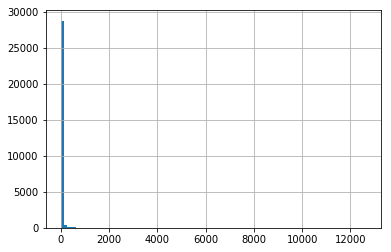

In [5]:
city_counts.hist(bins=100)

In [6]:
city_counts_cs = city_counts.cumsum()/(city_counts.sum())
city_counts_cs.head()

London, United Kingdom    0.015262
Tokyo, Japan              0.026731
New York, USA             0.036990
Paris, France             0.047134
Las Vegas, USA            0.055898
Name: city, dtype: float64

In [7]:
th = 0.9

In [8]:
above_th = city_counts_cs[city_counts_cs<th]
common_cities = above_th.index.values
print(above_th.shape)
above_th.head()

(5690,)


London, United Kingdom    0.015262
Tokyo, Japan              0.026731
New York, USA             0.036990
Paris, France             0.047134
Las Vegas, USA            0.055898
Name: city, dtype: float64

In [9]:
below_th = city_counts_cs[city_counts_cs>=th]
rare_cities = below_th.index.values
print(below_th.shape)
below_th.head()

(24078,)


Reading, USA                      0.900011
Sankt Englmar, Germany            0.900028
Santa Cruz de Mompox, Colombia    0.900045
Tamasopo, Mexico                  0.900062
Gili Air, Indonesia               0.900079
Name: city, dtype: float64

In [10]:
train_last.city.nunique()

29768

In [11]:
city_counts_cs.shape

(29768,)

### the distribution of number of city appearence

In [12]:
pd.value_counts(city_counts.values).head()

1    9488
2    4128
3    2513
4    1729
5    1351
dtype: int64

In [13]:
pd.value_counts(city_counts.values, normalize=True).cumsum()[:10]

1     0.318732
2     0.457404
3     0.541823
4     0.599906
5     0.645290
6     0.678581
7     0.705086
8     0.727257
9     0.746372
10    0.761422
dtype: float64

In [14]:
# unique value counts of city counts
len(set(city_counts.values))

636

majority (75% of unique city only appeared less than 10 times), one way to alleivate this is 

    1) bin rarely occursing cities to one
    2) use or add country info

### impression list length dist

In [16]:
train_last['imp_list'] = train_last.impressions.str.split('|')

In [17]:
imp_len = train_last.imp_list.str.len()
imp_len.value_counts().head()

25    628875
24     34223
11     12179
12     11560
13     10943
Name: imp_list, dtype: int64

In [18]:
imp_len.value_counts().tail()

5    4255
4    4008
3    3757
2    3562
1    3175
Name: imp_list, dtype: int64

In [19]:
train_last[train_last.imp_list.str.len()==1].city.isin(below_th.index).sum()

1496

In [20]:
train_last[train_last.imp_list.str.len()==2].city.isin(below_th.index).sum()

1504

### number of item_ids from common cities 

In [21]:
common_cities

array(['London, United Kingdom', 'Tokyo, Japan', 'New York, USA', ...,
       'Silverstone, United Kingdom', 'Aranđelovac, Serbia',
       'Parnamirim, Brazil'], dtype=object)

In [22]:
all_uniqe_item_ids = train_last.imp_list.values
all_uniqe_item_ids = [j for i in all_uniqe_item_ids for j in i]

In [23]:
all_item_id_counts = pd.value_counts(all_uniqe_item_ids)

In [24]:
all_item_id_counts.head()

8577    3914
8621    3903
8796    3854
8568    3602
8618    3597
dtype: int64

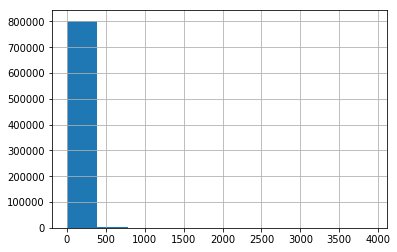

In [25]:
_ = all_item_id_counts.hist()

In [26]:
all_item_id_counts_cs = all_item_id_counts.cumsum()/(all_item_id_counts.sum())

In [27]:
above_th_item = all_item_id_counts_cs[all_item_id_counts_cs<th]
print(above_th_item.shape)

(258787,)


In [28]:
below_th_item = all_item_id_counts_cs[all_item_id_counts_cs>=th]
print(below_th_item.shape)

(549855,)


In [29]:
all_item_id_counts.shape

(808642,)

In [30]:
item_id_appearence_counts = pd.value_counts(all_item_id_counts.values)
item_id_appearence_counts.head()

1    185991
2     97150
3     64100
4     46846
5     37231
dtype: int64

In [31]:
item_id_appearence_counts.tail()

1315    1
1314    1
2650    1
801     1
3304    1
dtype: int64

In [32]:
(item_id_appearence_counts.cumsum()/(item_id_appearence_counts.sum())).head()

1    0.230004
2    0.350144
3    0.429413
4    0.487344
5    0.533386
dtype: float64

In [33]:
# now look at the item_ids from only common cities
train_common = train_last[train_last.city.isin(common_cities)].reset_index(drop=True)
common_item_ids = train_common.imp_list.values
common_item_ids = [j for i in common_item_ids for j in i]

In [34]:
common_item_ids_counts = pd.value_counts(common_item_ids)

In [35]:
common_item_ids_counts.head()

8577    3914
8621    3903
8796    3838
8568    3602
8618    3597
dtype: int64

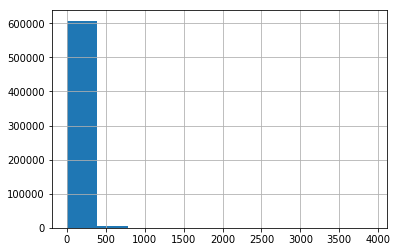

In [36]:
common_item_ids_counts.hist()

In [37]:
common_appearence = pd.value_counts(common_item_ids_counts.values)
(common_appearence.cumsum()/(common_appearence.sum())).head()

1    0.219276
2    0.329784
3    0.400814
4    0.452958
5    0.493544
dtype: float64

### intersection between impression list of different citys

### countries

In [38]:
countries = train_last.city.str.split(',').str[1]

In [39]:
countries_counts = countries.value_counts()
print(countries_counts.shape)
countries_counts.head()

(215,)


 Brazil            94477
 USA               79216
 Japan             59827
 United Kingdom    44337
 India             41078
Name: city, dtype: int64

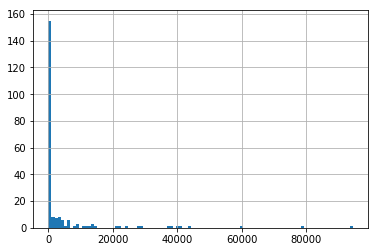

In [40]:
countries_counts.hist(bins=100)

In [41]:
pd.value_counts(countries_counts.values).head()

5    9
1    8
7    7
2    5
4    5
dtype: int64

In [42]:
pd.value_counts(countries_counts.values)[::-1].head()

5888     1
13960    1
2957     1
910      1
2960     1
dtype: int64

## now look at test

In [43]:
%%time
test = load_data('test')

CPU times: user 4.77 s, sys: 196 ms, total: 4.97 s
Wall time: 4.97 s


In [44]:
%%time
sub = load_data('submission_popular')

CPU times: user 624 ms, sys: 8.1 ms, total: 633 ms
Wall time: 632 ms


In [45]:
test_sub = test[test.session_id.isin(sub.session_id)].reset_index(drop=True)

In [46]:
test_sub['nimp'] = test_sub.impressions.str.split('|').str.len()

In [47]:
# sub[sub.session_id.isin(test_sub[test_sub.nimp==1].session_id)]

In [48]:
test_sub_last = test_sub.groupby('session_id').last().reset_index() # this may not be ideal

In [49]:
test_sub_last.shape

(253573, 13)

In [50]:
test_sub_city_counts = test_sub_last.city.value_counts()
test_sub_city_counts.head()

London, United Kingdom    3580
Tokyo, Japan              2784
Paris, France             2622
New York, USA             2507
Las Vegas, USA            2202
Name: city, dtype: int64

In [51]:
test_sub_city_counts_cs = test_sub_city_counts.cumsum()/(test_sub_city_counts.sum())
test_sub_city_counts_cs.head()

London, United Kingdom    0.014118
Tokyo, Japan              0.025097
Paris, France             0.035438
New York, USA             0.045324
Las Vegas, USA            0.054008
Name: city, dtype: float64

In [52]:
print(th)
test_sub_above_th = test_sub_city_counts_cs[test_sub_city_counts_cs<th]
print(test_sub_above_th.shape)
common_test_sub_cities = test_sub_above_th.index.values

0.9
(5487,)


number of common cities intersections with trains

In [53]:
len(set(common_test_sub_cities).intersection(common_cities))

4710

number of impression list with len 1

In [54]:
test_sub_last['imp_list'] = test_sub_last.impressions.str.split('|')

In [55]:
test_sub_imp_len = test_sub_last.imp_list.str.len()

In [56]:
test_sub_imp_len.value_counts()

25    192805
24     10620
11      3699
12      3627
13      3360
14      3205
15      3013
16      2901
17      2787
18      2722
19      2690
20      2444
21      2368
23      2224
22      2223
10      1774
9       1566
8       1454
7       1367
6       1286
5       1194
4       1189
3       1148
2       1041
1        866
Name: imp_list, dtype: int64

In [57]:
866/test_sub_last.shape[0]*100

0.34151901030472487

In [58]:
# test_sub_last[~test_sub_last.city.isin(common_test_sub_cities)].imp_list.str.len().value_counts()

### platform

In [ ]:
platfrom_counts = train_last

In [ ]:
# current filters